In [ ]:
!pip install thop
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary

In [ ]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [ ]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3)) #計算RGB通道的平均亮度
    std = np.std(data.numpy(), axis=(0,2,3))  #計算pixel和mean的偏離程度，偏離越多表示對比度越高
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset) #計算standard deviation and mean , 用於data augmentation
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

100%|██████████| 170M/170M [00:14<00:00, 11.8MB/s]


[0.49139854 0.4821559  0.4465293 ] [0.2470323  0.24348505 0.26158813]
[0.49139854 0.4821559  0.4465293 ] [0.2470323  0.24348505 0.26158813]


In [ ]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    # 同學實作部分：Add data augmentation here
    transforms.RandomCrop(32,padding=4),      # 先在圖片四周各填充4個像素，再從中隨機裁切出 32x32 的區域
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Transform to tensor & image normalization中的"Min/Max Normalization",將range縮在0~1 & Dimension Reordering
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    #模擬「遮擋」的情況。它會在圖片上隨機選擇一個矩形區域，並用隨機值（例如黑色或雜訊）來填充它。這強迫模型不要只依賴單一的顯著特徵，而是學習從物體的不同部分來辨識。
    transforms.Normalize(mean=train_mean, std=train_std), # Normalization(Standardization)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [ ]:
#此區為筆記區 記錄data augmentation的更多操作

#transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10), #PyTorch內建的CIFAR-10自動增強策略
#transforms.RandomRotation(degrees):
#作用：在指定的角度範圍內 (-degrees 到 +degrees) 隨機旋轉圖片。
#範例：transforms.RandomRotation(15) 會在 -15度 到 +15度 之間隨機旋轉。
#transforms.ColorJitter(brightness, contrast, saturation, hue):
#作用：隨機改變圖片的亮度、對比度、飽和度和色調。
#範例：transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2) 會在原始值的 [1-0.2, 1+0.2] 範圍內隨機調整這些屬性。
#transforms.RandomAffine(degrees, translate, scale):
#作用：一個更強大的轉換，可以同時進行旋轉、平移和縮放。
#範例：transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
#transforms.RandomErasing(p, scale, ratio):
#作用：模擬「遮擋」的情況。它會在圖片上隨機選擇一個矩形區域，並用隨機值（例如黑色或雜訊）來填充它。這強迫模型不要只依賴單一的顯著特徵，而是學習從物體的不同部分來辨識。
#注意：這個操作的對象是 Tensor，所以它必須放在 transforms.ToTensor() 之後！

In [ ]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
BATCH_SIZE = 128 #先設立128 稍後來測試256/64/32的結果
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1 #後面ResNet會用到,用來表示這個 block會把輸出的通道數放大幾倍。,ResNet18通常=1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection

        # 第一個Convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # Batch Normalization

        # 第二個Convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut Connection(實線部分)
        self.shortcut = nn.Sequential() # 先建立一個空的 Sequential

        #shortcut,虛線部分(若大小不一樣進行架構轉換)
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 學生實作部分：Define the ResNet-18 architecture using BasicBlock

        self.in_channels = 64 # 設定一個初始的輸入通道數，給第一個卷積層之後使用

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False) # 這一層負責接收 (3, 32, 32) 的圖片，輸出 (64, 32, 32) 的特徵圖
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet-18 的每個 layer 都有 2 個 BasicBlock
        # Layer1: 輸入 (64, 32, 32) -> 輸出 (64, 32, 32)
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks=2, stride=1)

        # Layer2: 輸入 (64, 32, 32) -> 輸出 (128, 16, 16)
        # stride=2 讓圖片尺寸減半
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks=2, stride=2)

        # Layer3: 輸入 (128, 16, 16) -> 輸出 (256, 8, 8)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks=2, stride=2)

        # Layer4: 輸入 (256, 8, 8) -> 輸出 (512, 4, 4)
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks=2, stride=2)

        #分類層
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 將 (512, 4, 4) 池化成 (512, 1, 1)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes) # 全連接層

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 學生實作部分：Define make_layer function to create layers of blocks

        strides = [stride] + [1] * (num_blocks - 1)
        layers = [] #準備一個空列表來存放要建立的所有block層

        # 根據 stride 列表，依序建立每一個 block
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers) #所有 block 層打包成一個單一的模組

    def forward(self, x):
        # 學生實作部分：Define the forward pass of ResNet-18
        out = F.relu(self.bn1(self.conv1(x)))

        #四層layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        #Classifier
        out = self.avgpool(out) #pooling
        out = out.view(out.size(0), -1) #flat
        out = self.linear(out) #Pass Fully-Connected layer

        return out

In [ ]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

model = ResNet18(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print model summary
summary(model, (3, 224, 224))

# Calculate FLOPs(模型的形狀) and Params(參數的數量)
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
        BasicBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
       BasicBlock-12         [-1, 64, 224, 224]               0
           Conv2d-13        [-1, 128, 112, 112]          73,728
      BatchNorm2d-14        [-1, 128, 1

In [ ]:
# Setting parameter
EPOCH = 50
pre_epoch = 0
lr = 0.01

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
criterion = nn.CrossEntropyLoss() #loss function -> Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=lr) #Gradient Decent ,adjust the weight to reduce loss

#lr_scheduler,動態調整lr
from torch.optim.lr_scheduler import StepLR
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) #每10個epoch，學習率變為原來的0.1倍

#lr_scheduler(CosineAnnealingLR)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = CosineAnnealingLR(optimizer, T_max=EPOCH) # 在T_max個epoch內，學習率會從0.001降到 0

best_model_path = 'best_resnet18.pth'

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # 學生實作部分：Complete the training and validation loop
    for batch_idx, (inputs, labels) in enumerate(trainloader): #training loop
        # 將資料和模型移動到同一個設備 (GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        # 1. 將優化器的梯度歸零
        optimizer.zero_grad()
        # 2. 前向傳播：將輸入餵給模型以獲得預測輸出
        outputs = model(inputs)
        # 3. 計算損失：比較模型預測和真實標籤
        loss = criterion(outputs, labels)
        # 4. 反向傳播：計算損失相對於模型參數的梯度
        loss.backward()
        # 5. 更新權重：優化器根據梯度更新模型參數
        optimizer.step()
        # 累計損失和計算準確率
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    # 計算整個訓練集上的平均損失和準確率
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #Validation Loop
    model.eval()  # 將模型切換到評估模式
    running_loss = 0.0
    correct = 0
    total = 0
    # 在評估階段，我們不需要計算梯度
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # 計算整個驗證集上的平均損失和準確率
    val_loss = running_loss / len(valloader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()#動態調整lr
    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)


    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch [1/50] Train Loss: 1.5320 | Train Acc: 43.53% | Val Loss: 1.3633 | Val Acc: 51.90%
Epoch [2/50] Train Loss: 1.0388 | Train Acc: 62.85% | Val Loss: 0.9375 | Val Acc: 66.96%
Epoch [3/50] Train Loss: 0.8233 | Train Acc: 70.83% | Val Loss: 0.8472 | Val Acc: 70.08%
Epoch [4/50] Train Loss: 0.6756 | Train Acc: 76.14% | Val Loss: 0.7312 | Val Acc: 74.48%
Epoch [5/50] Train Loss: 0.5794 | Train Acc: 79.79% | Val Loss: 0.6253 | Val Acc: 77.92%
Epoch [6/50] Train Loss: 0.5091 | Train Acc: 82.48% | Val Loss: 0.5796 | Val Acc: 80.60%
Epoch [7/50] Train Loss: 0.4553 | Train Acc: 83.93% | Val Loss: 0.5562 | Val Acc: 80.50%
Epoch [8/50] Train Loss: 0.4057 | Train Acc: 85.94% | Val Loss: 0.5032 | Val Acc: 82.76%
Epoch [9/50] Train Loss: 0.3793 | Train Acc: 86.95% | Val Loss: 0.4460 | Val Acc: 84.72%
Epoch [10/50] Train Loss: 0.3478 | Train Acc: 87.70% | Val Loss: 0.4402 | Val Acc: 84.90%
Epoch [11/50] Train Loss: 0.2379 | Train Acc: 91.85% | Val Loss: 0.3112 | Val Acc: 89.26%
Epoch [12/50] Train

In [ ]:
# Load the best model and evaluate on the test set
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")

Best Model Test Accuracy: 91.05%


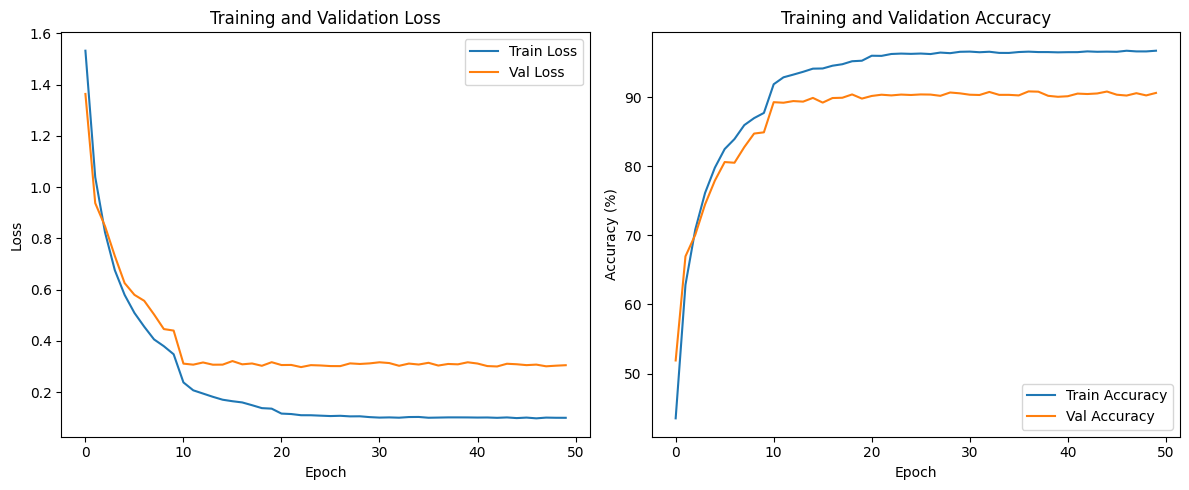

In [ ]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
# 學生實作部分：Plot training and validation loss and accuracy curves

# 建立一個畫布，其中包含 1 行 2 列的兩個子圖
# figsize=(12, 5) 設定了整個畫布的大小
plt.figure(figsize=(12, 5))
# --- 第一個子圖：損失 (Loss) ---
# plt.subplot(1, 2, 1) 表示在 1x2 的網格中，現在要畫第 1 個圖
plt.subplot(1, 2, 1)
# 畫出訓練損失曲線，標籤為 'Train Loss'
plt.plot(train_losses, label='Train Loss')
# 畫出驗證損失曲線，標籤為 'Val Loss'
plt.plot(val_losses, label='Val Loss')
# 設定圖表標題
plt.title('Training and Validation Loss')
# 設定 X 軸標籤
plt.xlabel('Epoch')
# 設定 Y 軸標籤
plt.ylabel('Loss')
# 顯示圖例 (就是 'Train Loss', 'Val Loss' 的標示)
plt.legend()

# --- 第二個子圖：準確率 (Accuracy) ---
# plt.subplot(1, 2, 2) 表示在 1x2 的網格中，現在要畫第 2 個圖
plt.subplot(1, 2, 2)
# 畫出訓練準確率曲線
plt.plot(train_accuracies, label='Train Accuracy')
# 畫出驗證準確率曲線
plt.plot(val_accuracies, label='Val Accuracy')
# 設定圖表標題
plt.title('Training and Validation Accuracy')
# 設定 X 軸標籤
plt.xlabel('Epoch')
# 設定 Y 軸標籤
plt.ylabel('Accuracy (%)')
# 顯示圖例
plt.legend()

# 調整子圖之間的間距，避免標題重疊
plt.tight_layout()

plt.show()